# Photo colorizing
The task is to colorize photos with CNNs
Used dataset: https://www.kaggle.com/arnaud58/landscape-pictures?select=00000001_%286%29.jpg

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
import PIL

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from skimage import io, transform
from PIL import Image

In [2]:
def to_grayscale(x):
    return (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 256, 256)

In [3]:
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
        filenames = np.array(os.listdir('data'))
        self.images = np.zeros(len(filenames), dtype=PIL.Image.Image)
        for i, filename in tqdm(enumerate(filenames)):
            with Image.open(''.join([data_path, str(os.path.sep), filename])) as image:
                self.images[i] = image.copy()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y
                    

In [4]:
data_path = 'data'
batch_size = 8
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-90, 90))
])

dataset = ColorizationDataset(data_path, to_grayscale, tfs)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

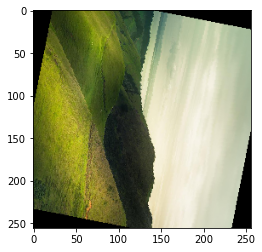

In [5]:
plt.imshow(dataset[0][1].transpose(0, 1).transpose(1,2))

In [6]:
# Class for our model.
# Обернуть в блоки.
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        
        self.postconcat = nn.Sequential(
            nn.Conv2d(129, 64, (3, 3), padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [7]:
num_epoch = 5
lr = 1e-3

model = Colorizer()
optimizer = torch.optim.Adam
criterion = nn.L1Loss()

In [8]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()


def train_model(model, optimizer_alg, criterion, train, epochs, lr):
    model = model.cuda()
    model.train()
    optimizer = optimizer_alg(model.parameters(), lr=lr)
    train_losses = []
    for epoch in range(epochs):
        for X, y in train:
            X = X.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()
        plt.figure((10,10))
        plt.subplot(141)
        plt.imshow(X)
        plt.subplot(142)
        plt.imshow(y)
        plt.subplot(143)
        plt.imshow(output)
    plt.figure(figsize=(15,10))
    plt.plot(train_losses)
    plt.show()

In [9]:
train_model(model, optimizer, criterion, loader, num_epoch, lr)

C:\Users\TOPAPEC\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: stack expects each tensor to be equal size, but got [3, 256, 256] at entry 0 and [4, 256, 256] at entry 1